# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
## important libary import
import numpy as np
import pandas as pd
import os
from skimage import io
import datetime
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
from keras import backend as K
import tensorflow as tf

In [4]:
#Access the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Here we set random seed to 30
np.random.seed(30)
rn.seed(30)
# tf.set_random_seed(30) Here we commented this line because of module 'tensorflow' has no attribute 'set_random_seed' that's why we need to use random.set_seed
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**Here we connect with drive to access our train and val csv data**

In [6]:
# Train.csv data path
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/train.csv').readlines())
#Val.csv data path
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/val.csv').readlines())
#Setting batch size to 10
batch_size = 10 #experiment with the batch size

In [7]:
#Here we resize the image with size 64
rows = 64
cols = 64

In [8]:
#lets understand the current distribution of class by visullaization
train_df = pd.DataFrame()
frame_name = []
frame_target = []
frame_class = []


for train_data in train_doc:
    data = train_data.split(";")
    frame_name.append(data[0])
    frame_target.append(data[1])
    frame_class.append(data[2].strip())
   
train_df["Video_Name"] = frame_name
train_df["Action_name"] = frame_target
train_df["Action_Class"] = frame_class

train_df.head()

,Video_Name,Action_name,Action_Class
0,WIN_20180926_16_54_08_Pro_Right_Swipe_new,Right_Swipe_new,1
1,WIN_20180925_18_02_58_Pro_Thumbs_Down_new,Thumbs_Down_new,3
2,WIN_20180925_17_33_08_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_51_17_Pro_Thumbs_Up_new,Thumbs_Up_new,4
4,WIN_20180926_17_17_35_Pro_Left_Swipe_new,Left_Swipe_new,0


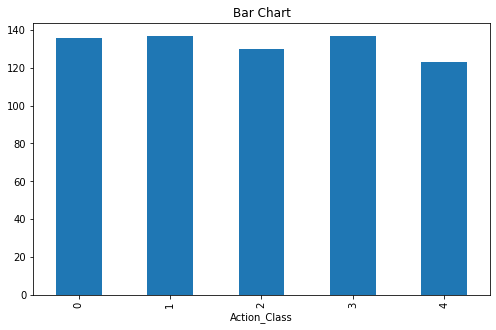

In [9]:
# Here we check the distribustion of class

train_df.Action_Class.value_counts()

size = [train_df.Action_Class.value_counts()[0],train_df.Action_Class.value_counts()[1],
        train_df.Action_Class.value_counts()[2],train_df.Action_Class.value_counts()[3],
        train_df.Action_Class.value_counts()[4]]
lables = ['3','1','0','2','4']

plt.figure(figsize=(18,5))

plt.subplot(1,2,2)
plt.title('Bar Chart')
train_df.groupby('Action_Class').Action_name.count().plot(kind='bar') #Balanced
plt.show()

# Generator
This is one of the most important part of the code. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. we have chosen `img_idx`, `y`,`z` and normalization in such a way that we get high accuracy.

**Image Resize Checking**

In [10]:
# Here we are doing the resize all the images to check all images are in same size or not
def crop_resize_img (image):
    if image.shape[0] != image.shape[1]:
        image = image[0:64,10:150]
    resized_image = cv2.resize(image, (64,64))
    return resized_image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(5,25)) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = 64
    z = 64
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = crop_resize_img(image)
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #yield the batch_data and the batch_labels
            

        
        # code for the remaining data points which are left after full batches
        if int(len(t)%batch_size!=0):
            rest_videos_count = int(len(t)%batch_size)
            for folder in range(rest_videos_count): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + ((num_batches)*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + ((num_batches)*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = crop_resize_img(image) #resizing the image
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). We have taken this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here we make the model using different functionalities that Keras provides. We have used `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We have used `TimeDistributed` while building a Conv2D + RNN model. Also we have considered that the last layer is the softmax and we have designed the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [15]:
#Here we use some more useful libraries thats required furthure
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Bidirectional,LSTM, SimpleRNN, GRU
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

#write your model here

Now that we have written the model, the next step is to `compile` the model. When we print the `summary` of the model, we'll see the total number of parameters we have to train.

In [16]:
frame = 20
rows = 64
cols = 64
channel_color = 3
num_classes = 5

#**Conv3d Model no:- 1**

In [17]:
#Here we are going to implement our first model
model = Sequential()

#First CNN Layer
model.add(Conv3D(32, kernel_size = (3,3,3), padding = "same", activation = "relu" , input_shape = (frame, rows, cols, channel_color)))
model.add(BatchNormalization())

#Second CNN Layer
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Third CNN Layer
model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Flatten layers
model.add(Flatten())

#Dense layer
model.add(Dense(256,  activation = "relu"))

#softmax layer
model.add(Dense(num_classes, activation = "softmax"))


In [18]:
### Here we choose an appropirate optimiser and loss function
## Here we use adam as optimiser it is gradient descent method.
## Here categorical_crossentropy this function used for loss function.
optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 64, 64, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 20, 64, 64, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 64, 64, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 64, 64, 64)   256       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 32, 32, 64)   0         
 )                                                               
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
print("filepath :->", filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

filepath :-> model_init_2022-07-1314_21_51.950577/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train steps_per_epoch: ", steps_per_epoch)
print("Validation validation_steps: ", validation_steps)

Train steps_per_epoch:  67
Validation validation_steps:  10


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Train the model:-1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 29.7196 - categorical_accuracy: 0.2836 Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 65.93421, saving model to model_init_2022-07-1312_46_10.826476/model-00001-29.71961-0.28358-65.93421-0.18000.h5
67/67 [==============================] - 3787s 57s/step - loss: 29.7196 - categorical_accuracy: 0.2836 - val_loss: 65.9342 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 2.5038 - categorical_accuracy: 0.2776
Epoch 2: val_loss improved from 65.93421 to 20.37901, saving model to model_init_2022-07-1312_46_10.826476/model-00002-2.50380-0.27761-20.37901-0.21000.h5
67/67 [==============================] - 61s 926ms/step - loss: 2.5038 - categorical_accuracy: 0.2776 - val_loss: 20.3790 - val_categor

In [38]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'], loc='upper left')

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'], loc='upper left')

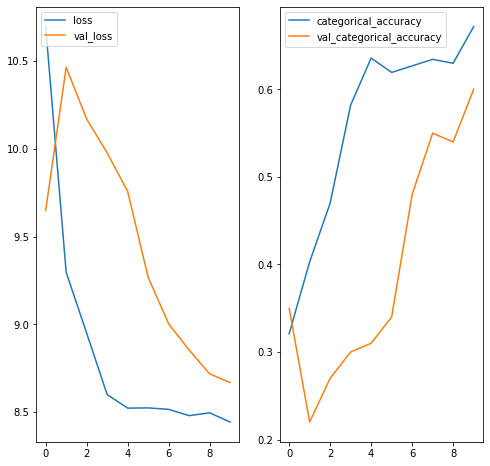

In [39]:
plot(history)

In [34]:
model_detail_df = pd.DataFrame()

In [31]:
def model_result(model_name ,accuracy, loss, val_accuracy, val_loss):
    model_detail_dic = {"Model Name" : model_name,
                   "Model Accuracy" : accuracy * 100,
                   "Validation Accuracy" : val_accuracy * 100,
                   "Model Loss" : loss * 100 ,
                   "Validation Loss" : val_loss * 100}

    df = pd.DataFrame([model_detail_dic])
    return df
    

In [35]:
df1 = model_result("Conv3d_Model_1",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

       Model Name  Model Accuracy  Validation Accuracy  Model Loss  \
0  Conv3d_Model_1       67.164177            60.000002  844.355679   

   Validation Loss  
0       866.861343  


#**Conv3d Model no:- 2 with L2 Regularization and "SGD" optimizer**



In [22]:
#Here we are going to try new optimizer 'sgd' same architecture with 10 epochs

#define model
model_2 = Sequential()

#First CNN Layer
model_2.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,64,64,3)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Second CNN Layer
model_2.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_2.add(Dropout(0.25))

#Third CNN Layer
model_2.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_2.add(Dropout(0.25))

#Fourth CNN Layer
model_2.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Flatten Layer
model_2.add(Flatten())

#Dense Layer
model_2.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model_2.add(Dropout(0.50))


#Softmax Layer
model_2.add(Dense(5, activation = 'softmax'))

#SGD optimiser on place of adam
optimiser = 'sgd'
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 64, 64, 16)    1312      
                                                                 
 batch_normalization_3 (Batc  (None, 20, 64, 64, 16)   64        
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 10, 32, 32, 16)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 32, 32, 32)    13856     
                                                                 
 batch_normalization_4 (Batc  (None, 10, 32, 32, 32)   128       
 hNormalization)                                                 
                                                      

**Train our model:-2**

In [26]:
history = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 10.6954 - categorical_accuracy: 0.3209 Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 9.64882, saving model to model_init_2022-07-1314_21_51.950577/model-00001-10.69535-0.32090-9.64882-0.35000.h5
67/67 [==============================] - 3502s 53s/step - loss: 10.6954 - categorical_accuracy: 0.3209 - val_loss: 9.6488 - val_categorical_accuracy: 0.3500 - lr: 0.0100
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 9.2964 - categorical_accuracy: 0.4030
Epoch 2: val_loss did not improve from 9.64882
67/67 [==============================] - 59s 889ms/step - loss: 9.2964 - categorical_accuracy: 0.4030 - val_loss: 10.4638 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 8.9499 - categorical_accuracy: 0.4701
Epoch 3: val_loss did not improve from 9.64882

Epoch 3: R

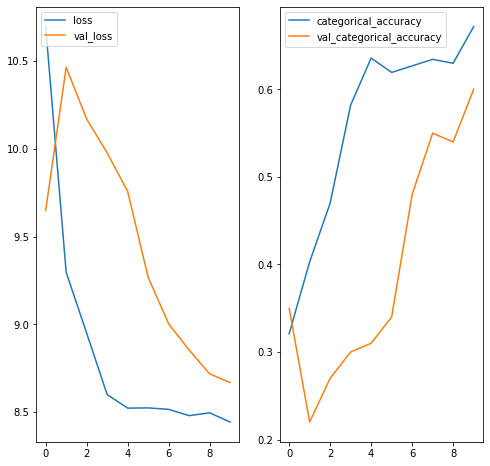

In [29]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'], loc='upper left')

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'], loc='upper left')
plot(history)

In [36]:
df1 = model_result("Conv3d_Model_2_SGD",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

           Model Name  Model Accuracy  Validation Accuracy  Model Loss  \
0      Conv3d_Model_1       67.164177            60.000002  844.355679   
0  Conv3d_Model_2_SGD       67.164177            60.000002  844.355679   

   Validation Loss  
0       866.861343  
0       866.861343  


#**Conv3d Model no:- 3 Add more CNN Layer**

In [37]:
#Here we are going to try some more cnn layer same architecture with 10 epochs

#define model
model_3 = Sequential()

#First CNN Layer
model_3.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,64,64,3)))
model_3.add(BatchNormalization())

model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Second CNN Layer
model_3.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model_3.add(BatchNormalization())

#Fourth CNN Layer
model_3.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Fifth CNN Layer
model_3.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model_3.add(BatchNormalization())

#Sixth CNN Layer
model_3.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Seventh CNN Layer
model_3.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model_3.add(BatchNormalization())

#Eighth CNN Layer
model_3.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Flatten Layer
model_3.add(Flatten())

#Dense Layer
model_3.add(Dense(256,kernel_regularizer=l2(0.01),activation='relu'))
model_3.add(Dropout(0.50))

model_3.add(Dense(5, activation = 'softmax'))

#'sgd' optimiser
optimiser = 'sgd'
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 20, 64, 64, 16)    1312      
                                                                 
 batch_normalization_7 (Batc  (None, 20, 64, 64, 16)   64        
 hNormalization)                                                 
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 32, 32, 16)   0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 10, 32, 32, 32)    13856     
                                                                 
 batch_normalization_8 (Batc  (None, 10, 32, 32, 32)   128       
 hNormalization)                                                 
                                                      

**Train our model:-3**

In [40]:
history = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 6.7836 - categorical_accuracy: 0.3597
Epoch 1: val_loss improved from 8.66861 to 6.32765, saving model to model_init_2022-07-1314_21_51.950577/model-00001-6.78364-0.35970-6.32765-0.25000.h5
67/67 [==============================] - 59s 882ms/step - loss: 6.7836 - categorical_accuracy: 0.3597 - val_loss: 6.3276 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 5.8273 - categorical_accuracy: 0.4239
Epoch 2: val_loss improved from 6.32765 to 5.86643, saving model to model_init_2022-07-1314_21_51.950577/model-00002-5.82729-0.42388-5.86643-0.32000.h5
67/67 [==============================] - 58s 883ms/step - loss: 5.8273 - categorical_accuracy: 0.4239 - val_loss: 5.8664 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 5.5170 - categorical_accuracy: 0.4881
Epoch 3: val_loss did not improve from 5

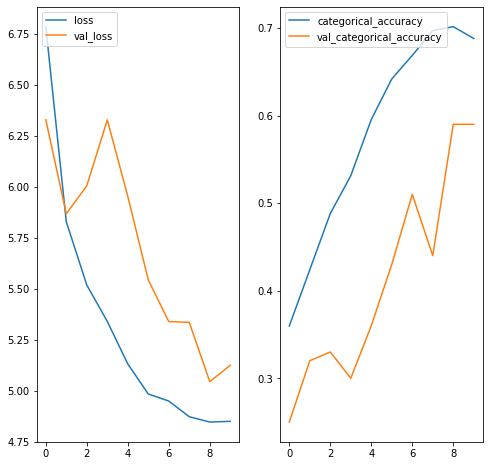

In [41]:
plot(history)

In [42]:
df1 = model_result("Conv3d_Model_3_cnn",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

           Model Name  Model Accuracy  Validation Accuracy  Model Loss  \
0      Conv3d_Model_1       67.164177            60.000002  844.355679   
0  Conv3d_Model_2_SGD       67.164177            60.000002  844.355679   
0  Conv3d_Model_3_cnn       68.805969            58.999997  484.895802   

   Validation Loss  
0       866.861343  
0       866.861343  
0       512.385941  


#**Conv3d Model no:- 4 Add Reducing Filter (2,2,2) & Added few more Hyper Tuning Paramaters**

In [43]:
#Here we are going to try Reduce the filter and add more hypertuning with 10 epochs

#define model
model_4 = Sequential()

#First CNN Layer
model_4.add(Conv3D(16, kernel_size=(2,2,2), padding='same', activation='relu',input_shape = (20,64,64,3)))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Second CNN Layer
model_4.add(Conv3D(32, kernel_size=(2,2,2), padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.25))

#Third CNN Layer
model_4.add(Conv3D(64, kernel_size=(2,2,2), padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.25))

#Fourth CNN Layer
model_4.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Flatten Layer
model_4.add(Flatten())

#Dense Layer
model_4.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model_4.add(Dropout(0.50))

#softmax Layer
model_4.add(Dense(5, activation = 'softmax'))

#adam optimiser
optimiser = 'adam'
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 20, 64, 64, 16)    400       
                                                                 
 batch_normalization_14 (Bat  (None, 20, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 10, 32, 32, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 10, 32, 32, 32)    4128      
                                                                 
 batch_normalization_15 (Bat  (None, 10, 32, 32, 32)   128       
 chNormalization)                                                
                                                      

**Train our model:-4**

In [44]:
history = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 11.0689 - categorical_accuracy: 0.3373
Epoch 1: val_loss did not improve from 5.04361
67/67 [==============================] - 60s 886ms/step - loss: 11.0689 - categorical_accuracy: 0.3373 - val_loss: 9.1008 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 6.6970 - categorical_accuracy: 0.4567
Epoch 2: val_loss did not improve from 5.04361
67/67 [==============================] - 58s 881ms/step - loss: 6.6970 - categorical_accuracy: 0.4567 - val_loss: 10.1307 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 5.4834 - categorical_accuracy: 0.4537
Epoch 3: val_loss did not improve from 5.04361

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
67/67 [==============================] - 58s 871ms/step - loss: 5.4834 - categorical_accuracy: 0.4537 - val_loss: 9.9631 -

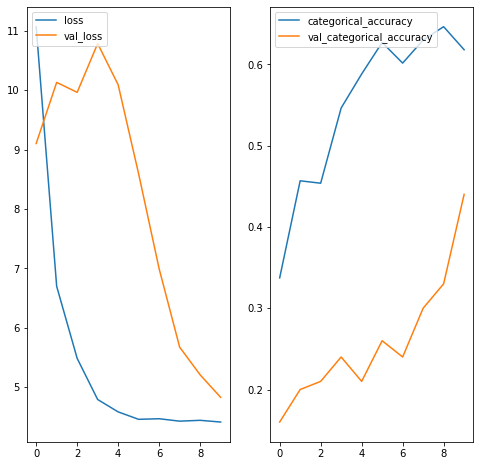

In [45]:
plot(history)

In [46]:
df1 = model_result("Conv3d_Model_4_filter",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

              Model Name  Model Accuracy  Validation Accuracy  Model Loss  \
0         Conv3d_Model_1       67.164177            60.000002  844.355679   
0     Conv3d_Model_2_SGD       67.164177            60.000002  844.355679   
0     Conv3d_Model_3_cnn       68.805969            58.999997  484.895802   
0  Conv3d_Model_4_filter       61.791044            44.000000  441.135550   

   Validation Loss  
0       866.861343  
0       866.861343  
0       512.385941  
0       482.717371  


#**Conv3d Model no:- 5 Add more dense layer**

In [47]:
#Here we are going to try Add more dense with 10 epochs

#define model
model_5 = Sequential()

#First CNN Layer
model_5.add(Conv3D(16, kernel_size=(2,2,2), padding='same', activation='relu',input_shape = (20,64,64,3)))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Second CNN Layer
model_5.add(Conv3D(32, kernel_size=(2,2,2), padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_5.add(Dropout(0.25))

#Third CNN Layer
model_5.add(Conv3D(64, kernel_size=(2,2,2), padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_5.add(Dropout(0.25))

#Fourth CNN Layer
model_5.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Flatten Layer
model_5.add(Flatten())

#Dense Layer
model_5.add(Dense(256,kernel_regularizer=l2(0.01),activation='relu'))
model_5.add(Dropout(0.50))
model_5.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model_5.add(Dropout(0.50))

#softmax Layer
model_5.add(Dense(5, activation = 'softmax'))

#adam optimiser
optimiser = 'adam'
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 20, 64, 64, 16)    400       
                                                                 
 batch_normalization_18 (Bat  (None, 20, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 10, 32, 32, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 10, 32, 32, 32)    4128      
                                                                 
 batch_normalization_19 (Bat  (None, 10, 32, 32, 32)   128       
 chNormalization)                                                
                                                      

**Train our model:-5**

In [48]:
history = model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 9.3608 - categorical_accuracy: 0.2463
Epoch 1: val_loss did not improve from 4.82717
67/67 [==============================] - 59s 874ms/step - loss: 9.3608 - categorical_accuracy: 0.2463 - val_loss: 9.7546 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 6.2531 - categorical_accuracy: 0.2955
Epoch 2: val_loss did not improve from 4.82717
67/67 [==============================] - 57s 865ms/step - loss: 6.2531 - categorical_accuracy: 0.2955 - val_loss: 11.7305 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 5.2566 - categorical_accuracy: 0.3015
Epoch 3: val_loss did not improve from 4.82717

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
67/67 [==============================] - 57s 868ms/step - loss: 5.2566 - categorical_accuracy: 0.3015 - val_loss: 13.5606 - 

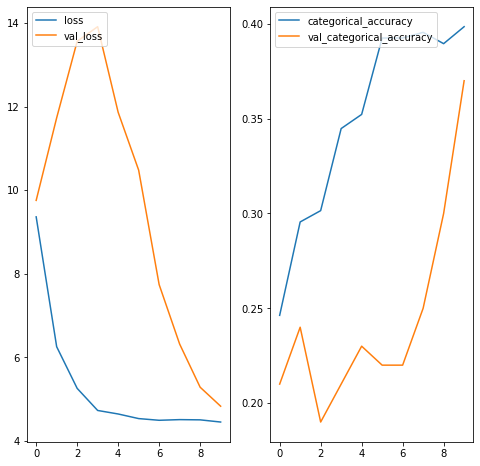

In [49]:
plot(history)

In [50]:
df1 = model_result("Conv3d_Model_5_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

              Model Name  Model Accuracy  Validation Accuracy  Model Loss  \
0         Conv3d_Model_1       67.164177            60.000002  844.355679   
0     Conv3d_Model_2_SGD       67.164177            60.000002  844.355679   
0     Conv3d_Model_3_cnn       68.805969            58.999997  484.895802   
0  Conv3d_Model_4_filter       61.791044            44.000000  441.135550   
0  Conv3d_Model_5_Tuning       39.850748            37.000000  445.098066   

   Validation Loss  
0       866.861343  
0       866.861343  
0       512.385941  
0       482.717371  
0       482.962847  


#**Model no:-6 CNN + SimpleRNN**

In [51]:
input_shape = (frame, rows, cols, channel_color)

In [52]:
#Here we are going to try CNN + SimpleRNN

#define model
model_6 = Sequential()

#First CNN Layer
model_6.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

#Second CNN Layer
model_6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

#Third CNN Layer
model_6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

#Fourth CNN Layer
model_6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

#Flatten Layer
model_6.add(TimeDistributed(Flatten()))

#SimpleRNN Layer
model_6.add(SimpleRNN(256))

#Dense Layer
model_6.add(Dense(256,activation='relu'))
model_6.add(Dropout(0.3))

model_6.add(Dense(5, activation='softmax'))

#First CNN Layer
optimiser = 'adam'
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 64, 64, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 32, 32, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 32, 32, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 32, 32, 32)  

**Train our model:-6**

In [53]:
history = model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.7001 - categorical_accuracy: 0.3149
Epoch 1: val_loss improved from 4.82717 to 2.65546, saving model to model_init_2022-07-1314_21_51.950577/model-00001-1.70008-0.31493-2.65546-0.21000.h5
67/67 [==============================] - 60s 876ms/step - loss: 1.7001 - categorical_accuracy: 0.3149 - val_loss: 2.6555 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.3382 - categorical_accuracy: 0.4701
Epoch 2: val_loss did not improve from 2.65546
67/67 [==============================] - 58s 871ms/step - loss: 1.3382 - categorical_accuracy: 0.4701 - val_loss: 3.1477 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.1707 - categorical_accuracy: 0.5433
Epoch 3: val_loss improved from 2.65546 to 2.23695, saving model to model_init_2022-07-1314_21_51.950577/model-00003-1.17074-0.54328-2.23695-0.26

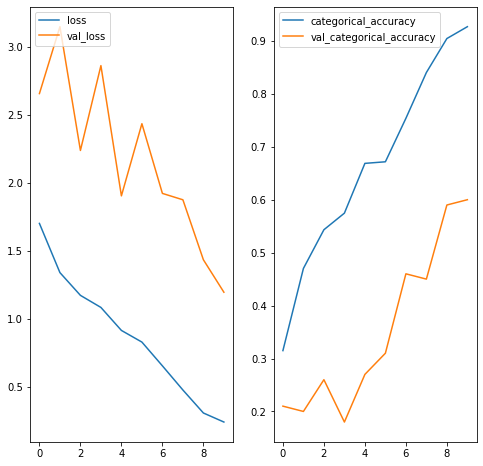

In [54]:
plot(history)

In [55]:
df1 = model_result("CNN+RNN_Model_6",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(12))

              Model Name  Model Accuracy  Validation Accuracy  Model Loss  \
0         Conv3d_Model_1       67.164177            60.000002  844.355679   
0     Conv3d_Model_2_SGD       67.164177            60.000002  844.355679   
0     Conv3d_Model_3_cnn       68.805969            58.999997  484.895802   
0  Conv3d_Model_4_filter       61.791044            44.000000  441.135550   
0  Conv3d_Model_5_Tuning       39.850748            37.000000  445.098066   
0        CNN+RNN_Model_6       92.686570            60.000002   23.862384   

   Validation Loss  
0       866.861343  
0       866.861343  
0       512.385941  
0       482.717371  
0       482.962847  
0       119.377935  


#**Model no:-7 CNN or LSTM** 

In [56]:
#Here we are going to try CNN + LSTM

#define model
model_7 = Sequential()

#First CNN Layer
model_7.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

#Second CNN Layer
model_7.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

#Third CNN Layer
model_7.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

#Fourth CNN Layer
model_7.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

#Flatten Layer
model_7.add(TimeDistributed(Flatten()))

#Apply LSTM
model_7.add(LSTM(128))

#Dense Layer
model_7.add(Dense(128,activation='relu'))
model_7.add(Dropout(0.3))

#softmax Layer
model_7.add(Dense(5, activation='softmax'))

#adam optimiser
optimiser = 'adam'
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 64, 64, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 32, 32, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 32, 32, 32)  

**Train our model:-7**

In [57]:
history = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.5365 - categorical_accuracy: 0.3239
Epoch 1: val_loss did not improve from 1.19378
67/67 [==============================] - 60s 865ms/step - loss: 1.5365 - categorical_accuracy: 0.3239 - val_loss: 1.8532 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.2944 - categorical_accuracy: 0.4836
Epoch 2: val_loss did not improve from 1.19378
67/67 [==============================] - 57s 864ms/step - loss: 1.2944 - categorical_accuracy: 0.4836 - val_loss: 2.0320 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.2284 - categorical_accuracy: 0.5119
Epoch 3: val_loss did not improve from 1.19378

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
67/67 [==============================] - 57s 864ms/step - loss: 1.2284 - categorical_accuracy: 0.5119 - val_loss: 2.6452 - va

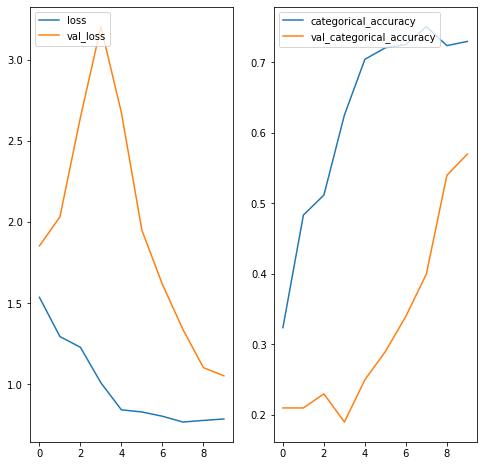

In [58]:
plot(history)

In [59]:
df1 = model_result("Model_no_7_CNN_or_LSTM",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(12))

               Model Name  Model Accuracy  Validation Accuracy  Model Loss  \
0          Conv3d_Model_1       67.164177            60.000002  844.355679   
0      Conv3d_Model_2_SGD       67.164177            60.000002  844.355679   
0      Conv3d_Model_3_cnn       68.805969            58.999997  484.895802   
0   Conv3d_Model_4_filter       61.791044            44.000000  441.135550   
0   Conv3d_Model_5_Tuning       39.850748            37.000000  445.098066   
0         CNN+RNN_Model_6       92.686570            60.000002   23.862384   
0  Model_no_7_CNN_or_LSTM       72.985077            56.999999   78.656095   

   Validation Loss  
0       866.861343  
0       866.861343  
0       512.385941  
0       482.717371  
0       482.962847  
0       119.377935  
0       105.263960  


#**Model no:-8 CNN or GRU** 

In [60]:
#Here we are going to try CNN + GRU model

#define model
model_8 = Sequential()

#First CNN Layer
model_8.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

#Second CNN Layer
model_8.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

#Third CNN Layer
model_8.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

#Fourth CNN Layer
model_8.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

#Flatten Layer
model_8.add(TimeDistributed(Flatten()))

#Apply GRU
model_8.add(GRU(256))

#Dense Layer
model_8.add(Dense(256,activation='relu'))
model_8.add(Dropout(0.4))

#softmax Layer
model_8.add(Dense(5, activation='softmax'))

#adam optimiser
optimiser = 'adam'
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_8.summary())


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 64, 64, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 20, 32, 32, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 20, 32, 32, 32)  

**Train our model:-8**

In [61]:
history = model_8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.6203 - categorical_accuracy: 0.3478
Epoch 1: val_loss did not improve from 1.05264
67/67 [==============================] - 61s 891ms/step - loss: 1.6203 - categorical_accuracy: 0.3478 - val_loss: 2.1885 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.2778 - categorical_accuracy: 0.4761
Epoch 2: val_loss did not improve from 1.05264
67/67 [==============================] - 58s 872ms/step - loss: 1.2778 - categorical_accuracy: 0.4761 - val_loss: 2.1762 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.1828 - categorical_accuracy: 0.5478
Epoch 3: val_loss did not improve from 1.05264
67/67 [==============================] - 57s 868ms/step - loss: 1.1828 - categorical_accuracy: 0.5478 - val_loss: 2.6436 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 4/10
67/67 [================

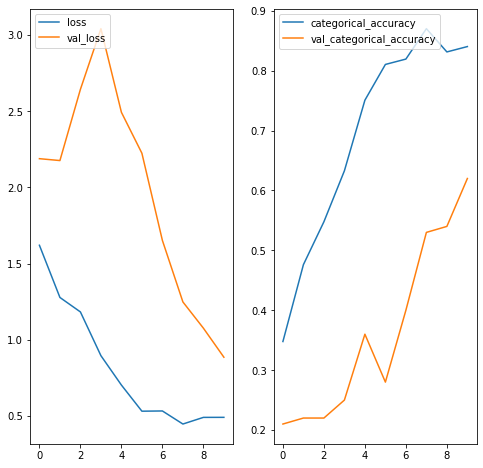

In [62]:
plot(history)

In [63]:
df1 = model_result("Model_no_8_CNN_or_GRU", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(12))

               Model Name  Model Accuracy  Validation Accuracy  Model Loss  \
0          Conv3d_Model_1       67.164177            60.000002  844.355679   
0      Conv3d_Model_2_SGD       67.164177            60.000002  844.355679   
0      Conv3d_Model_3_cnn       68.805969            58.999997  484.895802   
0   Conv3d_Model_4_filter       61.791044            44.000000  441.135550   
0   Conv3d_Model_5_Tuning       39.850748            37.000000  445.098066   
0         CNN+RNN_Model_6       92.686570            60.000002   23.862384   
0  Model_no_7_CNN_or_LSTM       72.985077            56.999999   78.656095   
0   Model_no_8_CNN_or_GRU       84.029853            62.000000   49.113473   

   Validation Loss  
0       866.861343  
0       866.861343  
0       512.385941  
0       482.717371  
0       482.962847  
0       119.377935  
0       105.263960  
0        88.562834  


**Here we can say that our model is avarage but in all model Model_no_8_CNN_or_GRU is little bit good as compare to other model**

In [65]:
from google.colab import files
files.download('/content/model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>